# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:24 - loss: 0.6945

  31/1875 [..............................] - ETA: 3s - loss: 0.5405   

  63/1875 [>.............................] - ETA: 2s - loss: 0.4580

  95/1875 [>.............................] - ETA: 2s - loss: 0.4154

 127/1875 [=>............................] - ETA: 2s - loss: 0.3884

 160/1875 [=>............................] - ETA: 2s - loss: 0.3683

 192/1875 [==>...........................] - ETA: 2s - loss: 0.3532

 225/1875 [==>...........................] - ETA: 2s - loss: 0.3405

 257/1875 [===>..........................] - ETA: 2s - loss: 0.3300

 288/1875 [===>..........................] - ETA: 2s - loss: 0.3212

 320/1875 [====>.........................] - ETA: 2s - loss: 0.3133

 352/1875 [====>.........................] - ETA: 2s - loss: 0.3062

 384/1875 [=====>........................] - ETA: 2s - loss: 0.2999

 416/1875 [=====>........................] - ETA: 2s - loss: 0.2941

 448/1875 [======>.......................] - ETA: 2s - loss: 0.2889

 480/1875 [======>.......................] - ETA: 2s - loss: 0.2840

 512/1875 [=======>......................] - ETA: 2s - loss: 0.2796

 543/1875 [=======>......................] - ETA: 2s - loss: 0.2756

 575/1875 [========>.....................] - ETA: 2s - loss: 0.2717

 608/1875 [========>.....................] - ETA: 2s - loss: 0.2680

 641/1875 [=========>....................] - ETA: 1s - loss: 0.2645

 672/1875 [=========>....................] - ETA: 1s - loss: 0.2614

 704/1875 [==========>...................] - ETA: 1s - loss: 0.2584

 734/1875 [==========>...................] - ETA: 1s - loss: 0.2557

 765/1875 [===========>..................] - ETA: 1s - loss: 0.2531

 797/1875 [===========>..................] - ETA: 1s - loss: 0.2505

 830/1875 [============>.................] - ETA: 1s - loss: 0.2479

 862/1875 [============>.................] - ETA: 1s - loss: 0.2455

 894/1875 [=============>................] - ETA: 1s - loss: 0.2433

 926/1875 [=============>................] - ETA: 1s - loss: 0.2411

 958/1875 [==============>...............] - ETA: 1s - loss: 0.2390

 990/1875 [==============>...............] - ETA: 1s - loss: 0.2370

1021/1875 [===============>..............] - ETA: 1s - loss: 0.2352

1053/1875 [===============>..............] - ETA: 1s - loss: 0.2333

1085/1875 [================>.............] - ETA: 1s - loss: 0.2316

1117/1875 [================>.............] - ETA: 1s - loss: 0.2299

1150/1875 [=================>............] - ETA: 1s - loss: 0.2282

1182/1875 [=================>............] - ETA: 1s - loss: 0.2266

1213/1875 [==================>...........] - ETA: 1s - loss: 0.2251

1246/1875 [==================>...........] - ETA: 1s - loss: 0.2235

1277/1875 [===================>..........] - ETA: 0s - loss: 0.2221

1307/1875 [===================>..........] - ETA: 0s - loss: 0.2208

1339/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1370/1875 [====================>.........] - ETA: 0s - loss: 0.2182

1402/1875 [=====================>........] - ETA: 0s - loss: 0.2169

1435/1875 [=====================>........] - ETA: 0s - loss: 0.2156

1472/1875 [======================>.......] - ETA: 0s - loss: 0.2142

1504/1875 [=======================>......] - ETA: 0s - loss: 0.2130

1536/1875 [=======================>......] - ETA: 0s - loss: 0.2118

1570/1875 [========================>.....] - ETA: 0s - loss: 0.2106

1604/1875 [========================>.....] - ETA: 0s - loss: 0.2095

1636/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1670/1875 [=========================>....] - ETA: 0s - loss: 0.2073

1705/1875 [==========================>...] - ETA: 0s - loss: 0.2062

1741/1875 [==========================>...] - ETA: 0s - loss: 0.2051

1774/1875 [===========================>..] - ETA: 0s - loss: 0.2041

1810/1875 [===========================>..] - ETA: 0s - loss: 0.2031

1846/1875 [============================>.] - ETA: 0s - loss: 0.2020

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2012


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1081

  40/1875 [..............................] - ETA: 2s - loss: 0.1109

  79/1875 [>.............................] - ETA: 2s - loss: 0.1110

 115/1875 [>.............................] - ETA: 2s - loss: 0.1109

 147/1875 [=>............................] - ETA: 2s - loss: 0.1107

 181/1875 [=>............................] - ETA: 2s - loss: 0.1106

 216/1875 [==>...........................] - ETA: 2s - loss: 0.1104

 249/1875 [==>...........................] - ETA: 2s - loss: 0.1102

 286/1875 [===>..........................] - ETA: 2s - loss: 0.1101

 324/1875 [====>.........................] - ETA: 2s - loss: 0.1099

 363/1875 [====>.........................] - ETA: 2s - loss: 0.1098

 403/1875 [=====>........................] - ETA: 2s - loss: 0.1096

 441/1875 [======>.......................] - ETA: 1s - loss: 0.1095

 480/1875 [======>.......................] - ETA: 1s - loss: 0.1094

 519/1875 [=======>......................] - ETA: 1s - loss: 0.1092

 556/1875 [=======>......................] - ETA: 1s - loss: 0.1091

 593/1875 [========>.....................] - ETA: 1s - loss: 0.1090

 627/1875 [=========>....................] - ETA: 1s - loss: 0.1089

 659/1875 [=========>....................] - ETA: 1s - loss: 0.1088

 695/1875 [==========>...................] - ETA: 1s - loss: 0.1087

 734/1875 [==========>...................] - ETA: 1s - loss: 0.1086

 773/1875 [===========>..................] - ETA: 1s - loss: 0.1085

 812/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 844/1875 [============>.................] - ETA: 1s - loss: 0.1083

 879/1875 [=============>................] - ETA: 1s - loss: 0.1082

 914/1875 [=============>................] - ETA: 1s - loss: 0.1081

 953/1875 [==============>...............] - ETA: 1s - loss: 0.1080

 992/1875 [==============>...............] - ETA: 1s - loss: 0.1079

1030/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1067/1875 [================>.............] - ETA: 1s - loss: 0.1077

1105/1875 [================>.............] - ETA: 1s - loss: 0.1076

1144/1875 [=================>............] - ETA: 1s - loss: 0.1075

1183/1875 [=================>............] - ETA: 0s - loss: 0.1074

1222/1875 [==================>...........] - ETA: 0s - loss: 0.1073

1261/1875 [===================>..........] - ETA: 0s - loss: 0.1072

1297/1875 [===================>..........] - ETA: 0s - loss: 0.1072

1327/1875 [====================>.........] - ETA: 0s - loss: 0.1071

1364/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1398/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1433/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1469/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1499/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1531/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1555/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1587/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1618/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1652/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1682/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1716/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1747/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1778/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1808/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1840/1875 [============================>.] - ETA: 0s - loss: 0.1061

1870/1875 [============================>.] - ETA: 0s - loss: 0.1061

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1061


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0987

  28/1875 [..............................] - ETA: 3s - loss: 0.0972

  57/1875 [..............................] - ETA: 3s - loss: 0.0969

  85/1875 [>.............................] - ETA: 3s - loss: 0.0970

 110/1875 [>.............................] - ETA: 3s - loss: 0.0972

 142/1875 [=>............................] - ETA: 3s - loss: 0.0973

 165/1875 [=>............................] - ETA: 3s - loss: 0.0974

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0975

 225/1875 [==>...........................] - ETA: 3s - loss: 0.0976

 256/1875 [===>..........................] - ETA: 2s - loss: 0.0977

 289/1875 [===>..........................] - ETA: 2s - loss: 0.0977

 325/1875 [====>.........................] - ETA: 2s - loss: 0.0977

 356/1875 [====>.........................] - ETA: 2s - loss: 0.0977

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0978

 462/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 535/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 567/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 601/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0978

 664/1875 [=========>....................] - ETA: 1s - loss: 0.0978

 701/1875 [==========>...................] - ETA: 1s - loss: 0.0978

 737/1875 [==========>...................] - ETA: 1s - loss: 0.0978

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 800/1875 [===========>..................] - ETA: 1s - loss: 0.0979

 836/1875 [============>.................] - ETA: 1s - loss: 0.0979

 875/1875 [=============>................] - ETA: 1s - loss: 0.0979

 908/1875 [=============>................] - ETA: 1s - loss: 0.0979

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1082/1875 [================>.............] - ETA: 1s - loss: 0.0979

1112/1875 [================>.............] - ETA: 1s - loss: 0.0979

1144/1875 [=================>............] - ETA: 1s - loss: 0.0979

1175/1875 [=================>............] - ETA: 1s - loss: 0.0979

1207/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1246/1875 [==================>...........] - ETA: 0s - loss: 0.0978

1285/1875 [===================>..........] - ETA: 0s - loss: 0.0978

1326/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1367/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1448/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1489/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1834/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0960

  42/1875 [..............................] - ETA: 2s - loss: 0.0947

  84/1875 [>.............................] - ETA: 2s - loss: 0.0953

 127/1875 [=>............................] - ETA: 2s - loss: 0.0955

 168/1875 [=>............................] - ETA: 2s - loss: 0.0955

 209/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 250/1875 [===>..........................] - ETA: 1s - loss: 0.0956

 290/1875 [===>..........................] - ETA: 1s - loss: 0.0956

 328/1875 [====>.........................] - ETA: 1s - loss: 0.0957

 368/1875 [====>.........................] - ETA: 1s - loss: 0.0957

 412/1875 [=====>........................] - ETA: 1s - loss: 0.0957

 455/1875 [======>.......................] - ETA: 1s - loss: 0.0957

 498/1875 [======>.......................] - ETA: 1s - loss: 0.0957

 540/1875 [=======>......................] - ETA: 1s - loss: 0.0958

 582/1875 [========>.....................] - ETA: 1s - loss: 0.0958

 622/1875 [========>.....................] - ETA: 1s - loss: 0.0958

 664/1875 [=========>....................] - ETA: 1s - loss: 0.0958

 707/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 747/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 788/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 830/1875 [============>.................] - ETA: 1s - loss: 0.0959

 871/1875 [============>.................] - ETA: 1s - loss: 0.0959

 913/1875 [=============>................] - ETA: 1s - loss: 0.0959

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1038/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1077/1875 [================>.............] - ETA: 0s - loss: 0.0959

1118/1875 [================>.............] - ETA: 0s - loss: 0.0959

1157/1875 [=================>............] - ETA: 0s - loss: 0.0959

1198/1875 [==================>...........] - ETA: 0s - loss: 0.0959

1239/1875 [==================>...........] - ETA: 0s - loss: 0.0959

1280/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1317/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1357/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1398/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1439/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1850/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0984

  41/1875 [..............................] - ETA: 2s - loss: 0.0953

  81/1875 [>.............................] - ETA: 2s - loss: 0.0956

 120/1875 [>.............................] - ETA: 2s - loss: 0.0956

 160/1875 [=>............................] - ETA: 2s - loss: 0.0955

 201/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 242/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 279/1875 [===>..........................] - ETA: 2s - loss: 0.0953

 319/1875 [====>.........................] - ETA: 1s - loss: 0.0953

 360/1875 [====>.........................] - ETA: 1s - loss: 0.0953

 401/1875 [=====>........................] - ETA: 1s - loss: 0.0953

 442/1875 [======>.......................] - ETA: 1s - loss: 0.0952

 483/1875 [======>.......................] - ETA: 1s - loss: 0.0952

 522/1875 [=======>......................] - ETA: 1s - loss: 0.0952

 554/1875 [=======>......................] - ETA: 1s - loss: 0.0952

 595/1875 [========>.....................] - ETA: 1s - loss: 0.0952

 636/1875 [=========>....................] - ETA: 1s - loss: 0.0952

 676/1875 [=========>....................] - ETA: 1s - loss: 0.0952

 717/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 754/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 793/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 834/1875 [============>.................] - ETA: 1s - loss: 0.0952

 875/1875 [=============>................] - ETA: 1s - loss: 0.0952

 914/1875 [=============>................] - ETA: 1s - loss: 0.0952

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1076/1875 [================>.............] - ETA: 1s - loss: 0.0952

1117/1875 [================>.............] - ETA: 0s - loss: 0.0952

1158/1875 [=================>............] - ETA: 0s - loss: 0.0952

1199/1875 [==================>...........] - ETA: 0s - loss: 0.0952

1242/1875 [==================>...........] - ETA: 0s - loss: 0.0952

1282/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1313/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1341/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1833/1875 [============================>.] - ETA: 0s - loss: 0.0953

1872/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

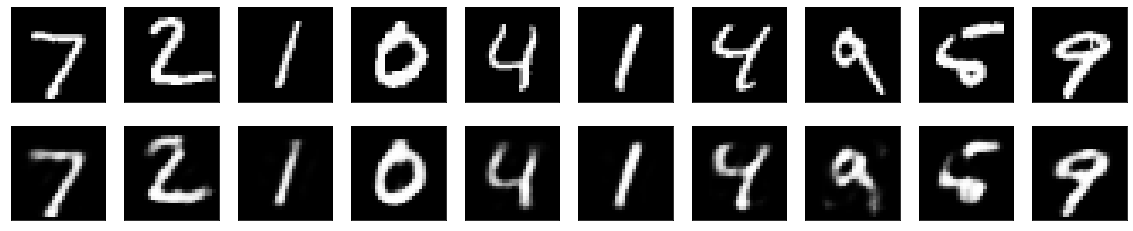

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
